# 粒子フィルタでローレンツ63モデルの双子実験

Lorenz方程式とは，カオス的振る舞いをする非線形方程式の一つ．
\\[\frac{du}{dt}=-pu+pv,\ \frac{dv}{dt}=-uw+ru-v,\ \frac{dw}{dt}=uv-bw\\]
で表される．Lorenzが1963に発表したモデルであることから，Lorenz'63 modelと呼ばれる．

## 前進差分による更新関数

In [1]:
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# update
def Lorenz_update(state, param, dt) :
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros(3)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state

# perfect simulation function
def Lorenz_perfect(initial, param, time, dt) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        state = Lorenz_update(state, param, dt)
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

# initial particle
def Initial_particle(mu_0, initial_sd, n_particle) :
    return rd.normal(mu_0, initial_sd, size = n_particle)

## 粒子フィルタ

In [3]:
class ParticleFilter(object):
    '''
    y [dim, time]: observation data
    n_dim : dimension of data
    n_particle : number of particles which use PF
    mu_0 [dim]: mu for initial normal distribution
    sigma_0 : sigma for initial normal distribution
    obs_sigma : variance of observation noise
    sys_sigma : variance of system noise
    initial_sd : sd for initial normal distribution
    parm : Lorenz parameters p, r, b
    dt : devision scale of time
    
    '''
    def __init__(self, y, n_dim = 3, n_particle = 1000, obs_sigma = 0.01, sys_sigma = 0.01,
                 mu_0 = (5.0, 5.0, 5.0), initial_sd = 0.1, param = (10, 28, 8/3), dt = 0.01):
        self.y = y
        self.n_dim = n_dim
        self.n_particle = n_particle
        self.obs_sigma = obs_sigma
        self.sys_sigma = sys_sigma
        self.mu_0 = mu_0
        self.initial_sd = initial_sd
        self.param = param
        self.dt = dt
        self.log_likelihood = - np.inf
    
    # likelihood for normal distribution
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2 * np.pi * s2))**(-1) * np.exp(-np.dot(y - x, y - x) / (2 * s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k + 1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle)) # labelの生成
        k_list = np.zeros(self.n_particle, dtype = np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size = self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1 / self.n_particle)
        u = [1 / self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed = 71):
        '''
        T : length of y
        x [time, dim, particle]: prediction distribution particles
        x_resampled [time, dim, particle]: filter distribution particles
        initial_x [dim, particle]: initial distribution of x
        w [time]: weight lambda of each particle
        w_normed [time]: normed weitht beta of each particle
        l [time]: log likelihood for each time
        v : system noise particles
        k : index number for resampling
        '''
        rd.seed(seed)

        # number of time-series data
        T = len(self.y)
        
        # initial filter, prediction
        x = np.zeros((T + 1, n_dim, self.n_particle))
        x_resampled = np.zeros((T + 1, n_dim, self.n_particle))
        
        # initial x
        for dim in range(n_dim) :
            initial_x = Initial_particle(self.mu_0[dim], self.initial_sd, self.n_particle)
            x_resampled[0, dim] = initial_x
            x[0, dim] = initial_x

        # weight
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        #l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                #  normal trend model
                v = rd.normal(0, np.sqrt(self.sys_sigma), size = n_dim) # System Noise
                x[t + 1, :, i] = Lorenz_update(x_resampled[t, :, i], self.param, self.dt) + v
            if (not any(np.isnan(self.y[t]))) :
                for i in range(self.n_particle) :
                    # likelihood for each particle for y[t]
                    w[t, i] = self.norm_likelihood(self.y[t], x[t+1, :, i], self.obs_sigma)
                # normalization
                w_normed[t] = w[t] / np.sum(w[t])
                # likelihood for each time
                #l[t] = np.log(np.sum(w[t]))

                # Resampling
                #k = self.resampling(w_normed[t]) # resampling
                k = self.resampling2(w_normed[t]) # resampling
                #print(x[t+1,:,k].shape)
                #print(x_resampled[t+1].shape)
                x_resampled[t + 1] = x[t + 1, :, k].T
            else :
                x_resampled[t + 1] = x[t + 1]
            
        # overall likelihood
        #self.log_likelihood = np.sum(l) - T * np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        #self.l = l
        
    def get_filtered_value(self, dim):
        #for i in range(n_dim) :
        #    filter_state[i] = np.diag(np.dot(self.w_normed, self.x[1:, i, :].T))
        return np.mean(self.x[1:, dim, :], axis = 1)
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, label = "data")
        plt.plot(self.get_filtered_value(), "g", label = "PF")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2,
                        alpha = 0.1)
        
        plt.legend(loc = 'upper right')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}"
                  .format(self.sigma_2, self.alpha_2, self.log_likelihood))

## 双子実験

双子実験：決定論的シミュレーションによって得られたデータを観測値とし，<br>
どれぐらいデータ同化による予測が一致しているか確認する手法．<br>
カオス系のLorenzモデルがよく用いられる．

In [5]:
# parameter
#a = -2
#b = -1
n_dim = 3
n_particle = 10**3 * 5
sys_sigma = 0.027
obs_sigma = 2.615
initial = np.array([5.0, 5.0, 5.0])
mu_0 = np.array([4.5, 5.5, 5.5])
initial_sd = 0.1
param = np.array([10, 28, 8 / 3])
dt = 0.01
time = 15.0

In [6]:
# perfect simulation
perf_u, perf_v, perf_w = Lorenz_perfect(initial, param, time, dt)

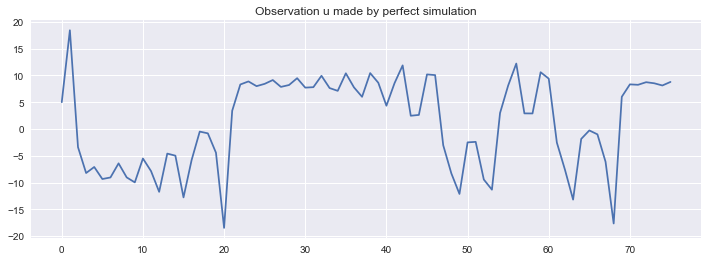

In [7]:
# plot observation from perfect simulation data
time_interval = 20
time_step = math.ceil(time / dt) + 1
time_data = np.linspace(0, time, time_step)
obs_u = np.zeros(time_step)
obs_v = np.zeros(time_step)
obs_w = np.zeros(time_step)
obs_u[:] = np.nan
obs_v[:] = np.nan
obs_w[:] = np.nan
obs_u[::time_interval] = perf_u[::time_interval]
obs_v[::time_interval] = perf_v[::time_interval]
obs_w[::time_interval] = perf_w[::time_interval]
plt.figure(figsize = (12, 4))
plt.plot(obs_u[::time_interval], label = 'obs_u')
plt.title("Observation u made by perfect simulation")
plt.show()

In [8]:
print(obs_u)

[ 5.                 nan         nan ...,         nan         nan
  8.77903351]


In [9]:
y = np.c_[obs_u, obs_v, obs_w]
y.shape

(1501, 3)

In [10]:
pf = ParticleFilter(y, n_dim, n_particle, obs_sigma, sys_sigma, mu_0, initial_sd, param, dt)
pf.simulate()

 calculating... t=1500

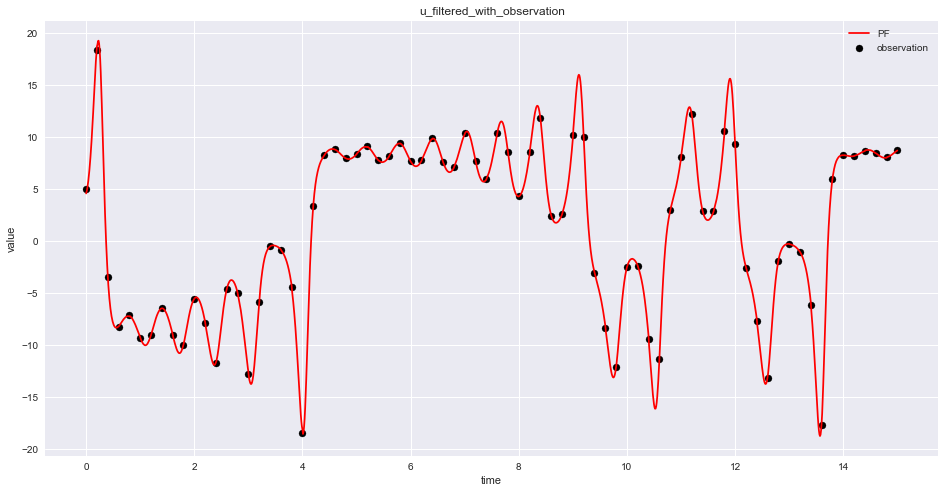

In [11]:
T = len(obs_u)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, pf.get_filtered_value(0), color = "r", label = "PF")
        
#for t in range(T):
#    plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2, alpha = 0.1)
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_filtered_with_observation")
plt.savefig("../plot/171109_twin_experiment_PF_u.png")
plt.show()

あまりにも完璧に一致してしまっている

## カルマンフィルターと比較してみる

[[  4.50684865   5.49370524   5.49986258]
 [  0.46069801   0.6172673   17.80703223]
 [  3.65690622   3.22864271  25.1968677 ]
 [  2.97891231   2.66957626  25.37787025]]


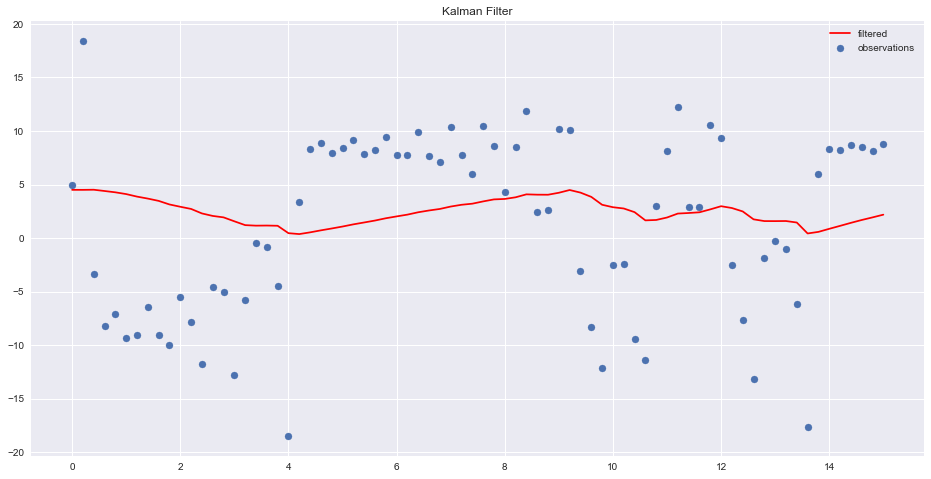

In [22]:
from pykalman import KalmanFilter
#kf = KalmanFilter(transition_matrices = np.array([[1, 1], [0, 1]]),
#                  transition_covariance = 0.0000001*np.eye(2))
kf = KalmanFilter(initial_state_mean = mu_0, initial_state_covariance = initial_sd * np.eye(3),
                  transition_covariance = sys_sigma * np.eye(3),
                  observation_covariance = obs_sigma * np.eye(3),
                  em_vars = ['transition_covariance', 'observation_covariance'])

kf.em(y[::time_interval], n_iter = 5)
#kalman_smooth_x = kf.smooth(df2)[0]
kalman_filter_x = kf.filter(y[::time_interval])[0]
print(kalman_filter_x[::time_interval])

transition_covariance = kf.transition_covariance
observation_covariance = kf.observation_covariance

plt.figure(figsize=(16, 8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], marker = "o", label="observations")
plt.plot(time_data[::time_interval], kalman_filter_x[:, 0], "r", label="filtered")
#plt.axhline(x, color="k", label="truth value")
plt.legend(loc = 'best')
plt.title('Kalman Filter')
plt.savefig('../plot/171109_kalman_filter_Lorenz.png')
plt.show()

In [24]:
print(transition_covariance)
print(observation_covariance)

[[ 0.13322882  0.11497194 -0.12045368]
 [ 0.11497194  0.14757844 -0.16130593]
 [-0.12045368 -0.16130593  0.74756532]]
[[  71.0487167    69.9746943   -23.29351134]
 [  69.9746943    84.40379082  -19.6377882 ]
 [ -23.29351134  -19.6377882   102.40443739]]


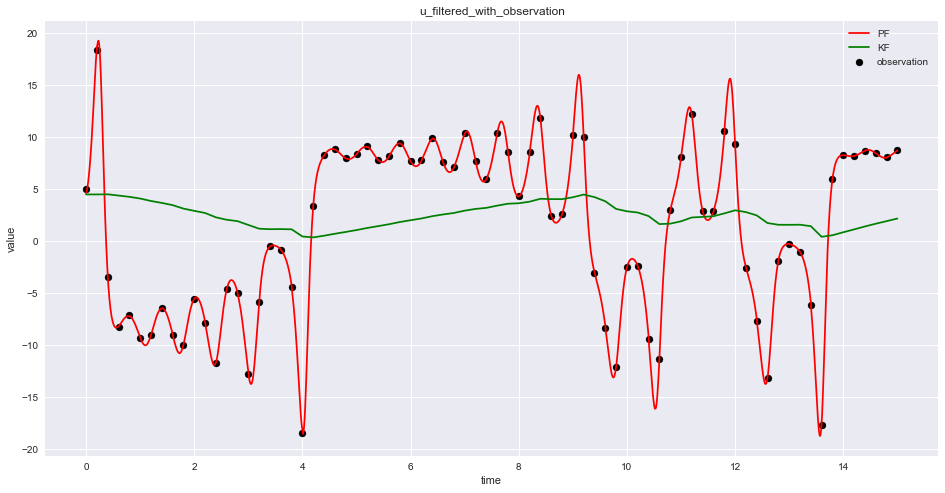

In [25]:
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, pf.get_filtered_value(0), color = "r", label = "PF")
plt.plot(time_data[::time_interval], kalman_filter_x[:, 0], color = "g", label="KF")

plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_filtered_with_observation")
plt.savefig("../plot/171109_twin_experiment_PF_with_KF_u.png")
plt.show()

考察・今後の展望
- KFでは，非線形の予測は行えないため，非常に悪い（推定制度の悪さは誤差を取らずとも明らか）結果が得られた．
- KFにおける，transition_matrices, observation_matrices を自動でチューニングすることができたとしてもあまり変わらないことが予想される．pykalman パッケージの pykalman.KalmanFilter のEMアルゴリズムで調整できるのは，transition_covariance, observation_covariance, initial_state_mean, initial_state_covariance のみである．
- pykalman に用意されている UnscentedKalmanFilter (無香料カルマンフィルタ)も試してみる．

無香料カルマンフィルタ（UKF）に関して
- pykalman，https://pykalman.github.io
- 西山清，http://www.ieice-hbkb.org/files/01/01gun_05hen_06m.pdf
- Qitta，https://qiita.com/g_rej55/items/618778dbb4bf286a985b

## 無香料カルマンフィルターと比較してみる

In [26]:
# prepare for transition_functions, observation_functions
def transition_functions(state, noise) :
    dt = 0.01
    time_interval = 20
    param = np.array([10, 28, 8 / 3])
    for i in range(time_interval) :
        state = Lorenz_update(state, param, dt) + noise
    return state

def observation_functions(state, noise) :
    return state + noise

[[  4.51841621   5.48158379   5.48158379]
 [-18.42143568 -18.83894507  40.78594347]
 [  4.33050444   4.55581829  21.75400937]
 [  9.39189959  -1.40097031  37.79703616]]


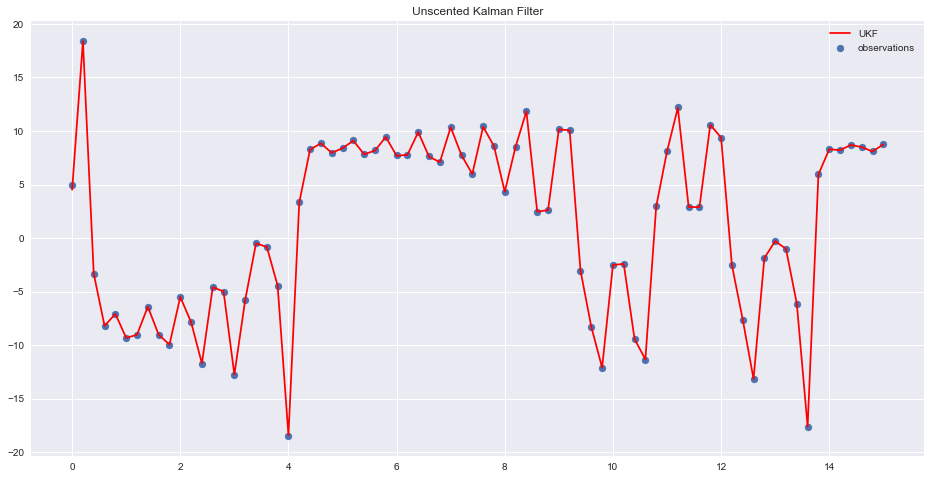

In [27]:
from pykalman import UnscentedKalmanFilter
#kf = KalmanFilter(transition_matrices = np.array([[1, 1], [0, 1]]),
#                  transition_covariance = 0.0000001*np.eye(2))
ukf = UnscentedKalmanFilter(initial_state_mean = mu_0, initial_state_covariance = initial_sd * np.eye(3),
                  transition_functions = transition_functions,
                  observation_functions = observation_functions,
                  transition_covariance = sys_sigma * np.eye(3),
                  observation_covariance = obs_sigma * np.eye(3))

unscented_kalman_filter_x = ukf.filter(y[::time_interval])[0]
print(unscented_kalman_filter_x[::time_interval])

plt.figure(figsize=(16, 8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], marker = "o", label="observations")
plt.plot(time_data[::time_interval], unscented_kalman_filter_x[:, 0], "r", label="UKF")
#plt.axhline(x, color="k", label="truth value")
plt.legend(loc = 'best')
plt.title('Unscented Kalman Filter')
plt.savefig('../plot/171109_unscented_kalman_filter_Lorenz.png')
plt.show()

考察・感想
- 最初にobservation data 生成するときにノイズ加えていないせいでPFもUKFも完全一致しているのかも
- 取り敢えず良い結果
- KFもUKFもパッケージを使っているせいでNanを無視して考えねばならなかった．PFはクラス内で調整したので，そういう意味では条件が一致していないのかも．

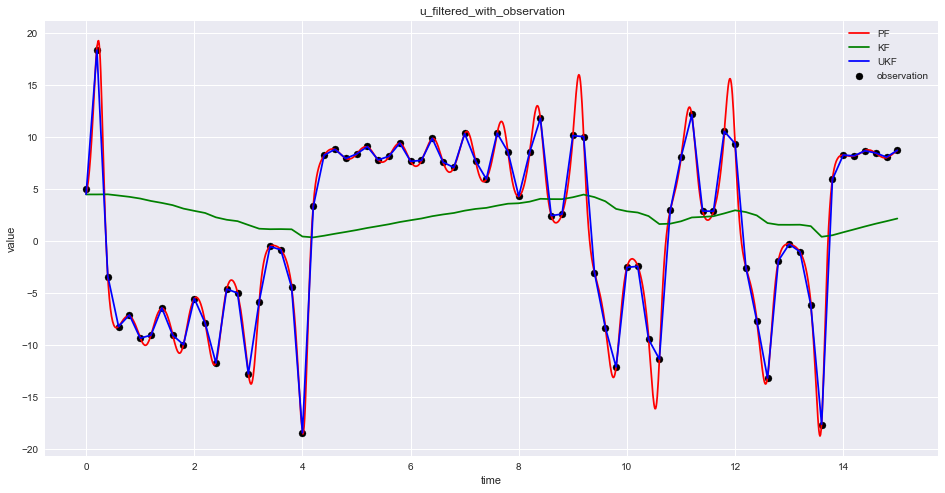

In [28]:
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, pf.get_filtered_value(0), color = "r", label = "PF")
plt.plot(time_data[::time_interval], kalman_filter_x[:, 0], color = "g", label="KF")
plt.plot(time_data[::time_interval], unscented_kalman_filter_x[:, 0], color = "b", label="UKF")

plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_filtered_with_observation")
plt.savefig("../plot/171109_twin_experiment_PF_with_KF_UKF_u.png")
plt.show()

今後の予定
- 文化祭休み全くやってなかったけど，取り敢えず実装はできた．
- PF,PSの実装完了＋KF,UKFの使い方習得．
- 実装面がある程度進んだので，今度は論文フェイズに入ろうかなと．
- 先行研究を幾つか見て，応用例や応用アルゴリズムを見ていきたい．（適宜実装？）